In [635]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import *
from keras.callbacks import Callback
import matplotlib
import csv
import six
import io

from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

In [640]:
N = 100
x_train = np.random.rand(N, 2)

def f(x_train):
    y_train = np.sin(x_train[:,0]**2 - x_train[:,1])
    return y_train

def plot_scalar_function(f, rng, model = False):
    """
    f -> function
    rng -> unit domain over dimensions
    model -> boolean
            If True: Keras Model
            else: Numpy Model
    """
    x = y = np.arange(-rng, rng, 0.05)
    X, Y = np.meshgrid(x, y)
    XX = np.vstack([np.ravel(X), np.ravel(Y)]).T
    
    if model:
        zs = f.predict(XX)
    else:
        zs = f(XX)
        
    Z = zs.reshape(X.shape)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    
def generate_keras_data(f, rng, N):
    """
    f -> Known numpy function
        Takes (N,2) Array 
        
    N -> number of samples
    
    rng -> size of square to sample over
        
    returns x_train, y_train
    
    x_train.shape = (2,N)
    y_train.shape = (1,N)
    """
    
    x_train = rng*(np.random.rand(N,2) - 0.5)
    y_train = np.expand_dims(f(x_train),1)
    
    return x_train, y_train


class grad_viewer(Callback):
    """
    Testing class to get items each call back!
    """
    def __init__(self, viewer_generator, filename, append = False):
        """
        Uses generate_keras_data to find sample grad!
        """
        self.validation_data = None
        self.model = None
        self.viewer_generator = viewer_generator
        self.built = False
        
        #### Select Random Layer, Random Varaible to keep track of
        #[f(x) if condition else g(x) for x in sequence]
        self.dense_layers = [i for (i,layer) in enumerate(model.layers)
                             if isinstance(layer, keras.layers.core.Dense)]
        #Selected on of the dense layers
        self.selected_dense_layers = np.random.choice(self.dense_layers)
        #Number of layers to know if the selected dense layers is the last
        self.num_layers = len(model.layers)
        if self.selected_dense_layers == (self.num_layers - 1):
            #Last Layer so final array is (model.layers.input_shape, 1)
            self.array_size = (model.layers[self.selected_dense_layers].input_shape[1],1)
        else:
            self.array_size = (model.layers[self.selected_dense_layers].input_shape[1],
                              model.layers[self.selected_dense_layers + 1].input_shape[1])
        self.array_x = np.random.choice(self.array_size[0])
        self.array_y = np.random.choice(self.array_size[1])
        print("Number of Layers in Model: %d" % self.num_layers)
        print("Indicies of Dense Layers in Model: %s" % self.dense_layers)
        print("Index of randomly selected Dense Layer: %d" % self.selected_dense_layers)
        print("Size of Randomly selected Dense Layer: %s" % str(self.array_size))
        print("X Index of Randomly selected Dense Layer %d" % self.array_x)
        print("Y Index of Randomly selected Dense Layer %d" % self.array_y)
        
        #### CSV Loger ####
        self.filename = filename
        self.append = append
        
        self.writer = None
        self.keys = ['weight', 'gradient']
        self.append_header = True
        
        if six.PY2:
            self.file_flags = 'b'
            self._open_args = {}
        else:
            self.file_flags = ''
            self._open_args = {'newline': '\n'}
        
    def on_train_begin(self, logs=None):
        if self.append:
            if os.path.exists(self.filename):
                with open(self.filename, 'r' + self.file_flags) as f:
                    self.append_header = not bool(len(f.readline()))
            mode = 'a'
        else:
            mode = 'w'
        self.csv_file = io.open(self.filename,
                                mode + self.file_flags,
                                **self._open_args)   
    
    def on_train_end(self, logs=None):
        self.csv_file.close()
        self.writer = None
    
    def on_batch_end(self, batch, logs=None):
        """
        grads show up in form:
        grads = []
        for layer in model.layers:
            grads.append(layer.gradients, bias.gradients)
        """
        logs = logs or {}
        
        if not self.built:
            weights = self.model.trainable_weights
            gradients = self.model.optimizer.get_gradients(self.model.total_loss, weights)
            input_tensors = self.model.inputs + self.model.sample_weights + self.model.targets + [K.learning_phase()]
            get_gradients = K.function(inputs=input_tensors, outputs=gradients)
            self.get_gradients = get_gradients
            self.built = True
        
        x, y = next(self.viewer_generator)
        inputs = [x, # X
                  [1], # sample weights
                  y, # y
                  0] # learning phase in TEST mode
                     
        grads = self.get_gradients(inputs)
        #Suppose Model = activation(A2(activations(A1*x + b1) + b2)) thus two stacked dense layers
        #Grads returns a list of [A1, b1, A2, b2]
        weight = self.model.layers[self.selected_dense_layers].get_weights()[0][self.array_x][self.array_y]
        grad = grads[2*self.selected_dense_layers][self.array_x][self.array_y]

        if not self.writer:
            class CustomDialect(csv.excel):
                delimiter = ','
            fieldnames = ['batch'] + self.keys
            if six.PY2:
                fieldnames = [unicode(x) for x in fieldnames]
            self.writer = csv.DictWriter(self.csv_file,
                                         fieldnames=fieldnames,
                                         dialect=CustomDialect)
            if self.append_header:
                self.writer.writeheader()

        row_dict = {'batch': batch}
        row_dict['weight'] =  weight
        row_dict['gradient'] = grad
        self.writer.writerow(row_dict)
        self.csv_file.flush()
        
        
def create_synced_generators(f, rng, batch_size):
    """
    returns two generators (Identical)
    (fit_generator, viewer_generator)
    """
    start_seed = np.random.randint(np.iinfo(np.int16).max)
    fit_generator = generator(f, rng, batch_size, start_seed)
    viewer_generator = generator(f, rng, batch_size, start_seed)
    return fit_generator, viewer_generator
        
def generator(f, rng, batch_size, seed):
    # Create empty arrays to contain batch of features and labels#
    while True:
        np.random.seed(seed)
        x_train, y_train = generate_keras_data(f, rng, batch_size)
        seed += 1
        yield x_train, y_train 

2001491893

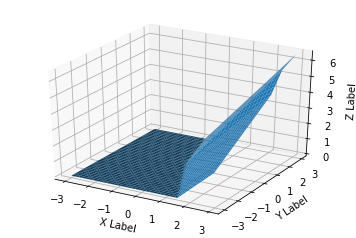

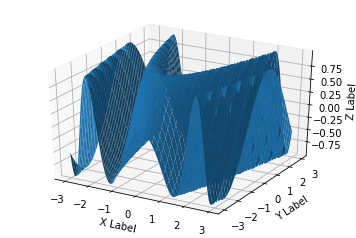

In [557]:
plot_scalar_function(model, 3, True)
plot_scalar_function(f,3)

In [630]:
opt = SGD(lr = 0.1)
model = Sequential()

model.add(Dense(units=2, activation='relu', input_dim=2))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['accuracy'])

print(model.count_params())

(<type 'basestring'>,)
<class 'keras.optimizers.Optimizer'>
47


In [641]:
#model.fit(x_train,y_train, epochs = 10)
x,y = create_synced_generators(f, 3, 10)
model.fit_generator(x, epochs = 1, steps_per_epoch= 3, verbose=2, 
          callbacks=[grad_viewer(y, 'testfile.csv')])

Number of Layers in Model: 3
Indicies of Dense Layers in Model: [0, 1, 2]
Index of randomly selected Dense Layer: 1
Size of Randomly selected Dense Layer: (2, 10)
X Index of Randomly selected Dense Layer 1
Y Index of Randomly selected Dense Layer 5
Epoch 1/1
 - 5s - loss: 0.2912 - acc: 0.0000e+00


keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (5.016928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (2.511830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


In [50]:
reload(gradient_viewer)

<module 'gradient_viewer' from 'gradient_viewer.pyc'>

In [13]:
model.fit(x_train_flat,y_train, epochs=2, steps_per_epoch= 1, callbacks = [gradient_viewer.TestCallBack(x_sample, y_sample)])

Epoch 1/2


FailedPreconditionError: Attempting to use uninitialized value dense_1/kernel
	 [[Node: _retval_dense_1/kernel_0_0 = _Retval[T=DT_FLOAT, index=0, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_1/kernel)]]